Spooky Author Identification
=============

Data Exploration
------------

This notebook will be used to import the data files, explore the style of each spooky author using different statistics of sentences, and fit models like Logistic Regression, XGBoost etc. using these sentence statistics as  features.

In [2]:
# All the modules that will be used later
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import FreqDist
import string
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
import xgboost as xgb

First, let's read the train set.

In [3]:
train = pd.read_csv('train.csv')
print('Train data size: ', train.shape)

Train data size:  (19579, 3)


In [4]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Let's check whether the classes are balanced in train dataset - whether the number of train examples of each author is close.

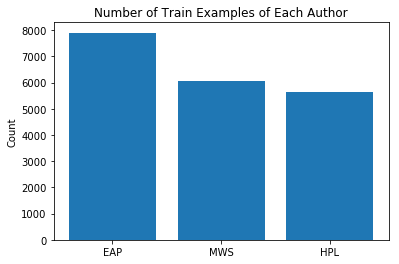

In [5]:
authors = train['author'].value_counts()
x_pos = np.arange(len(authors))
plt.figure()
plt.bar(x_pos, authors.values, align = 'center')
plt.xticks(x_pos, authors.index)
plt.ylabel('Count')
plt.title('Number of Train Examples of Each Author')
plt.show()

The classes look quite balanced in the train dataset.

Features
------------

Then, let's calculate some sentence statistics to explore the writing style of each author. The sentence statistics include:

- Number of words
- Proportion of unique words in the sentence
- Proportion of stop words in the sentence
- Proportion of punctuations in the sentence
- Proportion of nouns in the sentence
- Proportion of verbs in the sentence
- Average word length

As the lengths of sentences vary a lot in the train dataset, most of the statistics are normalized by sentence length, otherwise their distribution will be largely impacted by sentence length. In below statistics, punctuations are treated as words.

In [6]:
# Create a copy of train set to add features
train_feats = train.copy()

In [7]:
# Function to plot the distribution of sentence statistics
def plot_distribution(sentence_stat, xlim, xlabel):
    p = sns.kdeplot(train_feats[sentence_stat].loc[train_feats['author'] == 'EAP'], shade = True, color = 'r')
    p = sns.kdeplot(train_feats[sentence_stat].loc[train_feats['author'] == 'HPL'], shade = True, color = 'b')
    p = sns.kdeplot(train_feats[sentence_stat].loc[train_feats['author'] == 'MWS'], shade = True, color = 'y')
    p.set(xlabel = xlabel, xlim = xlim)
    p.legend(labels = ['EAP', 'HPL', 'MWS'])
    plt.show()

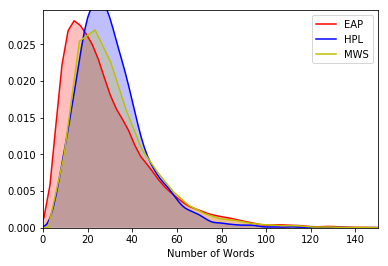

In [9]:
train_feats['length'] = train_feats['text'].apply(lambda t: len(word_tokenize(t)))
plot_distribution(sentence_stat = 'length', xlim = (0, 150), xlabel = 'Number of Words')

Seems that EAP tended to write in shorter sentences while HPL tended to write in longer ones. Then let's look at the proportion of unique words in the sentences.

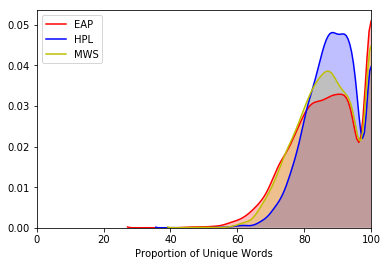

In [10]:
train_feats['unique'] = train_feats['text'].apply(lambda t: 100*float(len(np.unique(word_tokenize(t))))/float(len(word_tokenize(t))))
plot_distribution(sentence_stat = 'unique', xlim = (0, 100), xlabel = 'Proportion of Unique Words')

There seems to be no obvious difference between the three authors. Then let's look at the proportion of stop words in the sentence.

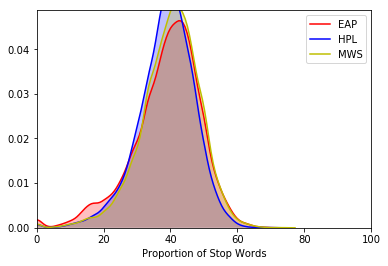

In [11]:
def count_stop_word(text):
    return len([w for w in word_tokenize(text) if w in stopwords.words('english')])

train_feats['stop'] = train_feats['text'].apply(lambda t: 100*float(count_stop_word(t))/float(len(word_tokenize(t))))
plot_distribution(sentence_stat = 'stop', xlim = (0, 100), xlabel = 'Proportion of Stop Words')

Seems that HPL tended to use slightly fewer stop words than EAP and MWS. Then let's look at the proportion of punctuations in the sentence. As we treat punctuations as single words, we still normalize the number of punctuation by number of words.

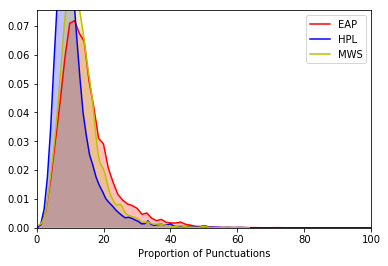

In [15]:
def count_punctuation(text):
    return len([c for c in text if c in string.punctuation])

train_feats['punctuation'] = train_feats['text'].apply(lambda t: 100*float(count_punctuation(t))/float(len(word_tokenize(t))))
plot_distribution(sentence_stat = 'punctuation', xlim = (0, 100), xlabel = 'Proportion of Punctuations')

Similar to stop words, seems that HPL tended to use fewer punctuations than EAP and MWS. Then let's look at the proportion of nouns and verbs in the sentence.

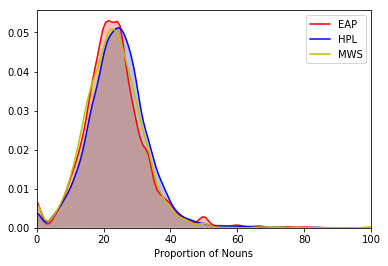

In [13]:
def count_noun(text):
    freq = FreqDist(tag for (word, tag) in pos_tag(word_tokenize(text)))
    noun_num = sum(num for tag, num in freq.items() if tag in ['NN', 'NNP', 'NNS'])
    return noun_num

train_feats['noun'] = train_feats['text'].apply(lambda t: 100*float(count_noun(t))/float(len(t.split())))
plot_distribution(sentence_stat = 'noun', xlim = (0, 100), xlabel = 'Proportion of Nouns')

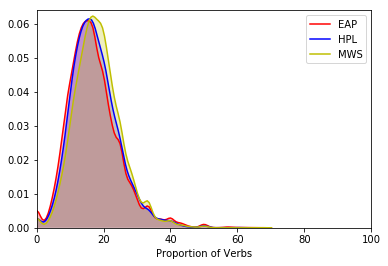

In [14]:
def count_verb(text):
    freq = FreqDist(tag for (word, tag) in pos_tag(word_tokenize(text)))
    verb_num = sum(num for tag, num in freq.items() if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
    return verb_num

train_feats['verb'] = train_feats['text'].apply(lambda t: 100*float(count_verb(t))/float(len(t.split())))
plot_distribution(sentence_stat = 'verb', xlim = (0, 100), xlabel = 'Proportion of Verbs')

Seems that MWS used more verbs than EAP and HPL. Then let's look at the average length of words each author used.

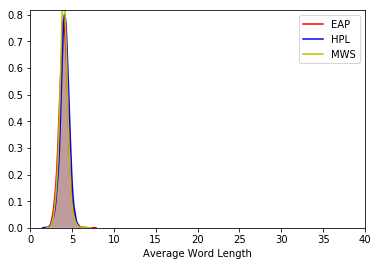

In [17]:
def avg_word_len(text):
    return np.mean([len(w) for w in word_tokenize(text)])

train_feats['avg_word_len'] = train_feats['text'].apply(lambda t: avg_word_len(t))
plot_distribution(sentence_stat = 'avg_word_len', xlim = (0, 40), xlabel = 'Average Word Length')

There is no obvious difference between the three authors. Then let's save the features for future use.

In [18]:
train_feats.to_csv('train_features.csv')

Models
------------

Now let's fit two widely used machine learning models, Logistic Regression and XGBoost, using the sentence statistics just created to predict the spooky authors.

In [20]:
# Features
X = train_feats[['length', 'unique', 'stop', 'punctuation', 'noun', 'verb', 'avg_word_len']]
X.shape

(19579, 7)

In [21]:
# Class labels
author_mapping = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y = train_feats['author'].map(author_mapping)
y.shape

(19579,)

Let's first fit a very simple Logistic Regression model and check the cross-validation log-loss.

In [23]:
# Run a 10-fold cross-validation using train set
lr_log_loss = []
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_val)
    lr_log_loss.append(metrics.log_loss(y_val, y_pred))

In [24]:
np.mean(lr_log_loss)

1.0441953327051976

The result is not that bad considering we are only using the sentence statistics to fit the model. Then let's fit XGBoost model using the same features.

In [25]:
def run_xgboost(X_train, y_train, X_val):
    param = {'silent': 1, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.5,
             'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 1001}
    plst = param.items()
    num_round = 1000
    dtrain = xgb.DMatrix(X_train, label = y_train)
    model = xgb.train(plst, dtrain, num_round)
    dtest = xgb.DMatrix(X_val)
    y_pred = model.predict(dtest, ntree_limit = model.best_ntree_limit)
    return model, y_pred

In [27]:
# Run a 10-fold cross-validation using train set
xgb_log_loss = []
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    model, y_pred = run_xgboost(X_train, y_train, X_val)
    xgb_log_loss.append(metrics.log_loss(y_val, y_pred))

In [28]:
np.mean(xgb_log_loss)

0.98633219562122376

The result is better than Logistic Regression. Let's plot the importance of each feature.

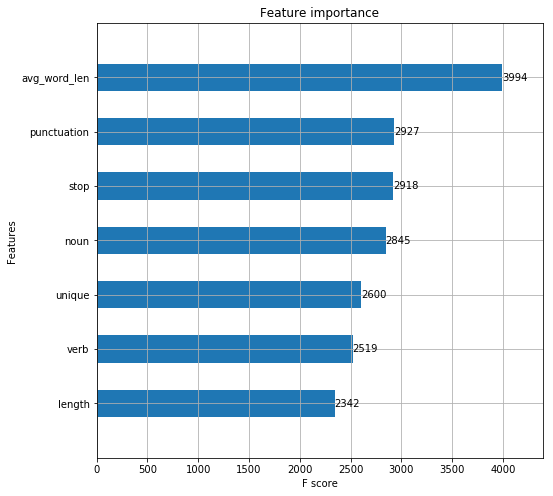

In [29]:
fig, ax = plt.subplots(figsize = (8, 8))
xgb.plot_importance(model, ax = ax, height = 0.5)
plt.show()

The average length of words each author used is the most important feature in differetiating the authors.

Reference
---------

[1] https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

[2] https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author